## Setup

### Conda/Miniconda
[Download](https://conda.io/miniconda.html) and install Miniconda. Select the Python 3.7 version or later. Don't select the Python 2.x version.

### AzureML Python SDK
Install the Python SDK:  make sure to install notebook, and contrib
```
conda create -n azureml -y Python=3.6 ipywidgets nb_conda
conda activate azureml
pip install --upgrade azureml-sdk[notebooks,contrib] scikit-image tensorflow tensorboardX --user 
jupyter nbextension install --py --user azureml.widgets
jupyter nbextension enable azureml.widgets --user --py
```

Install PyTorch:

On MacOS: 

    conda install pytorch torchvision -c pytorch

On Windows

    conda install pytorch -c pytorch
    pip install torchvision

You will need to restart jupyter after this
Detailed instructions are here: https://docs.microsoft.com/en-us/azure/machine-learning/service/quickstart-create-workspace-with-python 

### (Optional) Install VS Code and the VS Code extension 
[Download](https://code.visualstudio.com/) and install Visual Studio Code then the [Azure Machine Learning Extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.vscode-ai)
Make sure it has a recent version of the Python SDK -- remove the folder ~/.azureml/envs if there are issuse. A current SDK will be installed when you first use AML from VSCode.

### Clone this repository
```
git clone https://github.com/danielsc/dogbreeds
jupyter notebook
```

In [72]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.0.15


# Dog breed classification using Pytorch Estimators on Azure Machine Learning service

Have you ever seen a dog and not been able to tell the breed? Some dogs look so similar, that it can be nearly impossible to tell. For instance these are a few breeds that are difficult to tell apart:

#### Alaskan Malamutes vs Siberian Huskies
![Image of Alaskan Malamute vs Siberian Husky](http://cdn.akc.org/content/article-body-image/malamutehusky.jpg)

#### Whippet vs Italian Greyhound 
![Image of Whippet vs Italian Greyhound](http://cdn.akc.org/content/article-body-image/whippetitalian.jpg)

There are sites like http://what-dog.net, which use Microsoft Cognitive Services to be able to make this easier. 

In this tutorial, you will learn how to train a Pytorch image classification model using transfer learning with the Azure Machine Learning service. The Azure Machine Learning python SDK's [PyTorch estimator](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-train-pytorch) enables you to easily submit PyTorch training jobs for both single-node and distributed runs on Azure compute. The model is trained to classify dog breeds using the [Stanford Dog dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) and it is based on a pretrained ResNet18 model. This ResNet18 model has been built using images and annotation from ImageNet. The Stanford Dog dataset contains 120 classes (i.e. dog breeds), to save time however, for most of the tutorial, we will only use a subset of this dataset which includes only 10 dog breeds.

## The Problem
At the start, the user is running her workload on their local machine and finds it is slow -- even thought they are only training on 8% of the data.

In [ ]:
!mkdir outputs
!python pytorch_train.py --data_dir breeds-10 --num_epochs 10 --output_dir outputs 

## What is Azure Machine Learning service?
Azure Machine Learning service is a cloud service that you can use to develop and deploy machine learning models. Using Azure Machine Learning service, you can track your models as you build, train, deploy, and manage them, all at the broad scale that the cloud provides.
![](aml-overview.png)


## How can we use it for training image classification models?
Training machine learning models, particularly deep neural networks, is often a time- and compute-intensive task. Once you've finished writing your training script and running on a small subset of data on your local machine, you will likely want to scale up your workload.

To facilitate training, the Azure Machine Learning Python SDK provides a high-level abstraction, the estimator class, which allows users to easily train their models in the Azure ecosystem. You can create and use an Estimator object to submit any training code you want to run on remote compute, whether it's a single-node run or distributed training across a GPU cluster. For PyTorch and TensorFlow jobs, Azure Machine Learning also provides respective custom PyTorch and TensorFlow estimators to simplify using these frameworks.

### Steps to train with a Pytorch Estimator:
In this tutorial, we will:
- Connect to an Azure Machine Learning service Workspace 
- Create a remote compute target
- Upload your training data (Optional)
- Create your training script
- Create an Estimator object
- Submit your training job

## Create workspace

In the next step, you will create your own Workspace to use in this tutorial.

**You will be asked to login during this step. Please use your Microsoft AAD credentials.**

## Prerequisites
Make sure you have access to an Azure subscription. Your group's admin should have added you to your team's subscription. The subscriptions are listed [here](https://microsoft.sharepoint.com/teams/azuremlnursery/_layouts/OneNote.aspx?id=%2Fteams%2Fazuremlnursery%2FSiteAssets%2FAzure%20ML%20Nursery%20Notebook&wd=target%28Workshop.one%7C265D85D5-44C8-9D40-B556-A31FA098E708%2FPilot%20Subscriptions%7C430EF17A-82B2-4182-862F-0F47E87AB1C6%2F%29) (MS FTE credentials required) 

In [74]:
from azureml.core import Workspace

ws = Workspace.from_config()

print('https://ms.portal.azure.com/#@microsoft.onmicrosoft.com/resource' + ws.get_details()['id'])

Found the config file in: /Users/danielsc/git/dogbreeds/aml_config/config.json
https://ms.portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/4feb84f6-2c10-4536-9c8a-0a2360eabfc5/resourceGroups/azureml/providers/Microsoft.MachineLearningServices/workspaces/DanielSc


This will take a few minutes, so let's talk about what a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) is while it is being created.
![](aml-workspace.png)


## Create a remote compute target
For this tutorial, we will create an AML Compute cluster with a NC6s_v2, P100 GPU machines, created to use as the [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) to execute your training script on. 

**Creation of the cluster takes approximately 5 minutes, but we will not wait for it to complete** 

If the cluster is already in your workspace this code will skip the cluster creation process. Note that the code is not waiting for completion of the cluster creation. If needed you can call `compute_target.wait_for_completion(show_output=True)`, which will block you notebook until the compute target is provisioned.

In [75]:
from azureml.core.compute import AmlCompute, ComputeTarget

# choose a name for your cluster
cluster_name = "p100cluster"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6s_v2', 
                                                           idle_seconds_before_scaledown=1800,
                                                           min_nodes=0, 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    compute_target.wait_for_completion(show_output=True)

Found existing compute target.


## Attach the blobstore with the training data to the workspace
While the cluster is still creating, let's attach some data to our workspace.

The dataset we will use consists of ~150 images per class. Some breeds have more, while others have less. Each class has about 100 training images each for dog breeds, with ~50 validation images for each class. We will look at 10 classes in this tutorial.

To make the data accessible for remote training, you will need to keep the data in the cloud. AML provides a convenient way to do so via a [Datastore](https://docs.microsoft.com/azure/machine-learning/service/how-to-access-data). The datastore provides a mechanism for you to upload/download data, and interact with it from your remote compute targets. It is an abstraction over Azure Storage. The datastore can reference either an Azure Blob container or Azure file share as the underlying storage. 

You can view the subset of the data used [here](https://github.com/heatherbshapiro/pycon-canada/tree/master/breeds-10). Or download it from [here](https://github.com/heatherbshapiro/pycon-canada/master/breeds-10.zip) as a zip file. 

We already copied the data to an Azure blob storage container. To attach this blob container as a data store to your workspace, you use the `Datastore.register_azure_blob_container` function. You can copy the statement with the secrets filled in from [here](https://microsoft.sharepoint.com/teams/azuremlnursery/_layouts/OneNote.aspx?id=%2Fteams%2Fazuremlnursery%2FSiteAssets%2FAzure%20ML%20Nursery%20Notebook&wd=target%28Workshop.one%7C265D85D5-44C8-9D40-B556-A31FA098E708%2FDogbreeds%7C62F09F92-105C-7849-AF84-905BEE9F9588%2F%29) (requires Microsoft Employee login).

**If you already have the breeds datstore attached you can skip the next cell**

Now let's get a reference to the path on the datastore with the training data. We can do so using the `path` method. In the next section, we can then pass this reference to our training script's `--data_dir` argument. We will start with the 10 classes dataset.

In [40]:
from azureml.core import Datastore

ds = Datastore(ws, 'breeds')

path_on_datastore = 'breeds-10'
ds_data = ds.path(path_on_datastore)
print(ds_data)

$AZUREML_DATAREFERENCE_89b0d40c9da749fd8bc30434763d075e


## Up/Download Data

If you are interested in downloading the data locally, you can run `ds.download(".", 'breeds-10')`. This might take several minutes.

In [ ]:
ds.upload('breeds-10', 'breeds-10')

### Prepare training script
Now you will need to create your training script. In this tutorial, the training script is already provided for you at `pytorch_train.py`. In practice, you should be able to take any custom training script as is and run it with AML without having to modify your code.

However, if you would like to use AML's [tracking and metrics](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#metrics) capabilities, you will have to add a small amount of AML code inside your training script. 

In `pytorch_train.py`, we will log some metrics to our AML run. To do so, we will access the AML run object within the script:
```Python
from azureml.core.run import Run
run = Run.get_context()
```
Further within `pytorch_train.py`, we log the learning rate and momentum parameters, the best validation accuracy the model achieves, and the number of classes in the model:
```Python
run.log('lr', np.float(learning_rate))
run.log('momentum', np.float(momentum))
run.log('num_classes', num_classes)

run.log('best_val_acc', np.float(best_acc))
```

If you downloaded the data, you can start to train the model locally (note that it will take long if you don't have a GPU -- 21 min. on a Core i7 CPU).

**This step requires Pytorch to be installed locally -- find instructions [here](https://pytorch.org/#pip-install-pytorch)**


In [ ]:
!mkdir outputs
!python pytorch_train.py --data_dir breeds-10 --num_epochs 10 --output_dir outputs 

## Train model on the remote compute
Now that you have your data and training script prepared, you are ready to train on your remote compute cluster. You can take advantage of Azure compute to leverage GPUs to cut down your training time. 

### Create an experiment
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) to track all the runs in your workspace for this transfer learning PyTorch tutorial. 

In [77]:
from azureml.core import Experiment

experiment_name = 'pytorch-dogs' 
experiment = Experiment(ws, name=experiment_name)

### Create a PyTorch estimator
The AML SDK's PyTorch estimator enables you to easily submit PyTorch training jobs for both single-node and distributed runs. For more information on the PyTorch estimator, refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-train-pytorch). The following code will define a single-node PyTorch job.

In [87]:
##BATCH AI
from azureml.train.dnn import PyTorch

script_params = {
    '--data_dir': ds_data.as_mount(),
    '--num_epochs': 10,
    '--output_dir': './outputs',
    '--log_dir': './logs',
    '--mode': 'fine_tune'
}

estimator10 = PyTorch(source_directory='.', 
                    script_params=script_params,
                    compute_target=compute_target, 
                    entry_script='pytorch_train.py',
                    pip_packages=['tensorboardX'],
                    use_gpu=True)


In [88]:
print(estimator10.run_config.environment.docker.base_image)

mcr.microsoft.com/azureml/base-gpu:0.2.1


In [89]:
print(estimator10.conda_dependencies.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults
  - torch==1.0.0
  - torchvision==0.2.1
  - tensorboardX



The `script_params` parameter is a dictionary containing the command-line arguments to your training script `entry_script`. Please note the following:
- We passed our training data reference `ds_data` to our script's `--data_dir` argument. This will 1) mount our datastore on the remote compute and 2) provide the path to the training data `breeds` on our datastore.
- We specified the output directory as `./outputs`. The `outputs` directory is specially treated by AML in that all the content in this directory gets uploaded to your workspace as part of your run history. The files written to this directory are therefore accessible even once your remote run is over. In this tutorial, we will save our trained model to this output directory.

To leverage the Azure VM's GPU for training, we set `use_gpu=True`.

In [90]:
run = experiment.submit(estimator10)

In [91]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### What happens during a run?
If you are running this for the first time, the compute target will need to pull the docker image, which will take about 2 minutes. This gives us the time to go over how a **Run** is executed in Azure Machine Learning. 

Note: had we not created the workspace with an existing ACR, we would have also had to wait for the image creation to be performed -- that takes and extra 10-20 minutes for big GPU images like this one. This is a one-time cost for a given python configuration, and subsequent runs will then be faster. We are working on ways to make this image creation faster.

![](aml-run.png)

### Distributed training

Now that the setup is working, we can go to the full dataset with 120 classes. We just need to point to a different path on the datastore. 

In [92]:
full_dataset = ds.path('breeds')
print(full_dataset)

$AZUREML_DATAREFERENCE_6536f2be6e5348f9bcdd7fe1d13776ef


Running the model on multiple nodes is simple (in this case using Horovod MPI-based algorithm running on 4 nodes)

In [93]:
## AML Compute
from azureml.train.dnn import PyTorch

script_params = {
    '--data_dir': full_dataset.as_mount(),
    '--num_epochs': 25,
    '--output_dir': './outputs',
    '--log_dir': './logs',
    '--mode': 'fine_tune'
}

estimator120 = PyTorch(source_directory='.', 
                        script_params=script_params,
                        compute_target=compute_target, 
                        pip_packages=['tensorboardX'],
                        entry_script='pytorch_train_horovod.py',
                        node_count=4,
                        distributed_backend='mpi',
                        use_gpu=True)

run120 = experiment.submit(estimator120)

In [94]:
from azureml.widgets import RunDetails
RunDetails(run120).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [23]:
from azureml.contrib.tensorboard import Tensorboard

# The Tensorboard constructor takes an array of runs, so be sure and pass it in as a single-element array here
tb = Tensorboard([run120])

# If successful, start() returns a string with the URI of the instance.
tb.start()

http://FIN-SIN-AOI01.europe.corp.microsoft.com:6006


'http://FIN-SIN-AOI01.europe.corp.microsoft.com:6006'

In [97]:
tb.stop()

Training on 4 nodes completes in about 10 minutes and achieves 76% accuracy, which is similar to accuracy produced by single node training. This is great improvement of training time.

### Hyperparameter Tuning
 Now that you have trained an initial model, you can tune the hyperparameters of this model to optimize model performance. Azure ML allows you to automate this tuning, in an efficient manner via early termination of poorly performing runs.

You can configure your Hyperparamter Tuning experiment by specifying the following info -
- Define the hyparparameter space - specify ranges, distribution and sampling
- Early Termination policy
- Optimization metric
- Resource / Compute budget
- Desired concurrency


In [98]:
from azureml.widgets import RunDetails
from azureml.train.hyperdrive import *

ps = RandomParameterSampling(
    {
        '--momentum': uniform(0.6,0.99),
        '--learning_rate': loguniform(-6, -3)
    }
)

policy = BanditPolicy(evaluation_interval=2, slack_factor=0.2)


hdc = HyperDriveRunConfig(estimator=estimator10, 
                          hyperparameter_sampling=ps, 
                          policy=policy, 
                          primary_metric_name='best_val_acc', 
                          primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                          max_total_runs=50,
                          max_concurrent_runs=4)

hd_run = experiment.submit(hdc)
RunDetails(hd_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

While the jobs is running, take a look at the [Hyperdrive documentation](https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.hyperdrive?view=azure-ml-py) to see what other options Hyperdrive offers.

In [99]:
# at any time, you can pull out the metrics generated so far from the runs
hd_run.get_metrics()

{}

In [ ]:
x = ws.experiments['pytorch-dogs']

In [ ]:
from azureml.core import ScriptRun
r = ScriptRun(x, 'pytorch-dogs_1544650210935_9')

In [ ]:
r.download_file('outputs/model.pt')

## Inferencing
### Create scoring script

First, we will create a scoring script that will be invoked by the web service call. Note that the scoring script must have two required functions:
* `init()`: In this function, you typically load the model into a `global` object. This function is executed only once when the Docker container is started. 
* `run(input_data)`: In this function, the model is used to predict a value based on the input data. The input and output typically use JSON as serialization and deserialization format, but you are not limited to that.

Refer to the scoring script `pytorch_score.py` for this tutorial. Our web service will use this file to predict the dog breed based on a 120 class model trained earlier, located in the folder `model`. We will test the scoring file locally first before you go and deploy the web service.

1. Import the scoring script, so that init() and run() are accessible

In [100]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pytorch_score

2. Call the init function -- this will load the model and the class_names from the model directory

In [ ]:
pytorch_score.init()

3. Add some helper functions:

In [102]:
import os, json, base64
from io import BytesIO
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
import urllib.request
import io, requests

##Get random dog
def get_random_dog():
    r = requests.get(url ="https://dog.ceo/api/breeds/image/random")
    URL= r.json()['message']
    return URL

def imgToBase64(img):
    """Convert pillow image to base64-encoded image"""
    imgio = BytesIO()
    img.save(imgio, 'JPEG')
    img_str = base64.b64encode(imgio.getvalue())
    return img_str.decode('utf-8')

4. Find an image of a dog and call the run() function

/Users/danielsc/git/dogbreeds/pytorch_score.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)


https://images.dog.ceo/breeds/wolfhound-irish/n02090721_708.jpg
{'label': 'n02090721-Irish_wolfhound', 'probability': '0.6530122'}


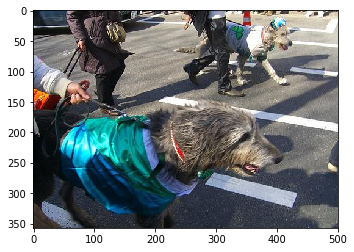

In [103]:
##Get Random Dog Image
URL = get_random_dog()

with urllib.request.urlopen(URL) as url:
    test_img = io.BytesIO(url.read())


plt.imshow(Image.open(test_img))

base64Img = imgToBase64(Image.open(test_img))

result = pytorch_score.run(input_data=json.dumps({'data': base64Img}))
print(URL)
print(json.loads(result))

### Register the model
Once the run completes, we can register the model that was created.

**Please use a unique name for the model**

In [ ]:
from azureml.core.model import Model
model = Model.register(ws, model_name='model', model_path = 'model', description='120 Dogbreeds')
print(model.name, model.id, model.version, sep = '\t')

## Deploy model as web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances (ACI), Azure Kubernetes Service (AKS), IoT edge device, or field programmable gate arrays (FPGAs)

ACI is generally cheaper than AKS and can be set up in 4-6 lines of code. ACI is the perfect option for testing deployments. Later, when you're ready to use your models and web services for high-scale, production usage, you can deploy them to AKS.


In this tutorial, we will deploy the model as a web service in [Azure Container Instances](https://docs.microsoft.com/en-us/azure/container-instances/) (ACI). 


For more information on deploying models using Azure ML, refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-deploy-and-where).

### Create environment file
Then, we will need to create an environment file (`myenv.yml`) that specifies all of the scoring script's package dependencies. This file is used to ensure that all of those dependencies are installed in the Docker image by AML. In this case, we need to specify `torch`, `torchvision`, `pillow`, and `azureml-sdk`.

In [ ]:
%%writefile myenv.yml
name: myenv
channels:
  - defaults
dependencies:
  - pip:
    - torch
    - torchvision
    - pillow
    - azureml-core

### Configure the container image
Now configure the Docker image that you will use to build your ACI container.

In [ ]:
from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(execution_script='pytorch_score.py', 
                                                  runtime='python', 
                                                  conda_file='myenv.yml',
                                                  description='Image with dog breed model')

### Configure the ACI container
We are almost ready to deploy. Create a deployment configuration file to specify the number of CPUs and gigabytes of RAM needed for your ACI container. While it depends on your model, the default of `1` core and `1` gigabyte of RAM is usually sufficient for many models.

In [ ]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'data': 'dog_breeds',  'method':'transfer learning', 'framework':'pytorch'},
                                               description='Classify dog breeds using transfer learning with PyTorch')

### Deploy the registered model
Finally, let's deploy a web service from our registered model. First, retrieve the model from your workspace.

In [ ]:
from azureml.core.model import Model

model = ws.models['model']

Then, deploy the web service using the ACI config and image config files created in the previous steps. We pass the `model` object in a list to the `models` parameter. If you would like to deploy more than one registered model, append the additional models to this list.

** Please use a unique service name**

In [ ]:
%%time
from azureml.core.webservice import Webservice

service_name = 'dog120'
service = Webservice.deploy_from_model(workspace=ws,
                                       name=service_name,
                                       models=[model],
                                       image_config=image_config,
                                       deployment_config=aciconfig,)

service.wait_for_deployment(show_output=True)
print(service.state)

If your deployment fails for any reason and you need to redeploy, make sure to delete the service before you do so: `service.delete()`

**Tip: If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:**

In [ ]:
print(service.get_logs())

Get the web service's HTTP endpoint, which accepts REST client calls. This endpoint can be shared with anyone who wants to test the web service or integrate it into an application.

In [27]:
service = ws.webservices['dog120']
print(service.scoring_uri)

http://52.236.144.243:80/score


### Test the web service
Finally, let's test our deployed web service. We will send the data as a JSON string to the web service hosted in ACI and use the SDK's `run` API to invoke the service. Here we will take an arbitrary image from online to predict on. This is the same as above, but now we are testing on our own trained model. You can use any dog image, but please remember we only trained on 10 classes.

https://images.dog.ceo/breeds/saluki/n02091831_2858.jpg


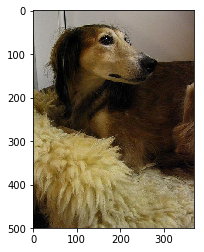

In [35]:
##Get Random Dog Image
URL = get_random_dog()

with urllib.request.urlopen(URL) as url:
    test_img = io.BytesIO(url.read())

plt.imshow(Image.open(test_img))

with urllib.request.urlopen(URL) as url:
    test_img = io.BytesIO(url.read())

plt.imshow(Image.open(test_img))
print(URL)

In [36]:
def imgToBase64(img):
    """Convert pillow image to base64-encoded image"""
    imgio = BytesIO()
    img.save(imgio, 'JPEG')
    img_str = base64.b64encode(imgio.getvalue())
    return img_str.decode('utf-8')

base64Img = imgToBase64(Image.open(test_img))

result = service.run(input_data=json.dumps({'data': base64Img}))
print(json.loads(result))

{'label': 'n02099601-golden_retriever', 'probability': '0.7896181'}


### Delete web service
Once you no longer need the web service, you should delete it.

In [ ]:
service.delete()

In [4]:
%%time 
import time
time.sleep(5)

CPU times: user 708 µs, sys: 1.7 ms, total: 2.41 ms
Wall time: 5 s


In [7]:
import os
os.name

'posix'

In [8]:
os.name == 'posix'

True

In [10]:
from azureml.core.runconfig import PythonEnvironment
??PythonEnvironment

{'dog120': <azureml.core.webservice.aci.AciWebservice at 0x11276feb8>}